# NHS Age Group Prediction using Machine Learning

## Objective:
The goal is to build a binary classifier to distinguish between Adult (age < 65) and Senior (age ≥ 65) individuals based on physiological and lifestyle data from the NHANES survey.


In [71]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, learning_curve,cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)

In [72]:
# Load data
train = pd.read_csv("Train_Data (1).csv")
test = pd.read_csv("Test_Data (1).csv")

In [73]:
train.head()

,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1954 non-null   float64
 1   RIAGENDR   1948 non-null   float64
 2   PAQ605     1953 non-null   float64
 3   BMXBMI     1948 non-null   float64
 4   LBXGLU     1953 non-null   float64
 5   DIQ010     1948 non-null   float64
 6   LBXGLT     1955 non-null   float64
 7   LBXIN      1957 non-null   float64
 8   age_group  1952 non-null   object 
dtypes: float64(8), object(1)
memory usage: 138.4+ KB


In [75]:
train.isnull().sum()

SEQN         12
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64

In [76]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("Duplicate rows:", train.duplicated().sum())


Train shape: (1966, 9)
Test shape: (312, 8)
Duplicate rows: 0


In [77]:
# Encode target
train['age_group'] = train['age_group'].map({'Adult': 0, 'Senior': 1})

In [92]:
print("Before cleaning target:")
print(train['age_group'].isnull().sum())

# Remove rows with missing target
train = train.loc[train['age_group'].notnull()].reset_index(drop=True)

print("After cleaning target:")
print(train['age_group'].isnull().sum())

Before cleaning target:
0
After cleaning target:
0


In [79]:
print(train['age_group'].value_counts())

age_group
0.0    1638
1.0     314
Name: count, dtype: int64


In [80]:
print(train['age_group'].value_counts(normalize=True))


age_group
0.0    0.839139
1.0    0.160861
Name: proportion, dtype: float64


In [81]:
for df in [train, test]:
    df['HOMA_IR'] = (df['LBXGLU'] * df['LBXIN']) / 405

In [82]:
for df in [train, test]:
    df['high_glucose'] = (df['LBXGLU'] > 125).astype(int)
    df['high_insulin'] = (df['LBXIN'] > 25).astype(int)

In [83]:
# BMI categorization function
def bmi_category(bmi):
    if pd.isna(bmi): return np.nan
    elif bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal'
    elif bmi < 30: return 'Overweight'
    else: return 'Obese'

In [84]:
train['BMI_cat'] = train['BMXBMI'].apply(bmi_category)
test['BMI_cat'] = test['BMXBMI'].apply(bmi_category)

In [85]:
def clip_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)
        df[col] = df[col].clip(Q1, Q3)
    return df

num_clip_cols = ['BMXBMI','LBXGLU','LBXGLT','LBXIN','HOMA_IR']

train = clip_outliers(train, num_clip_cols)
test = clip_outliers(test, num_clip_cols)


## Exploratory Data Analysis (EDA)

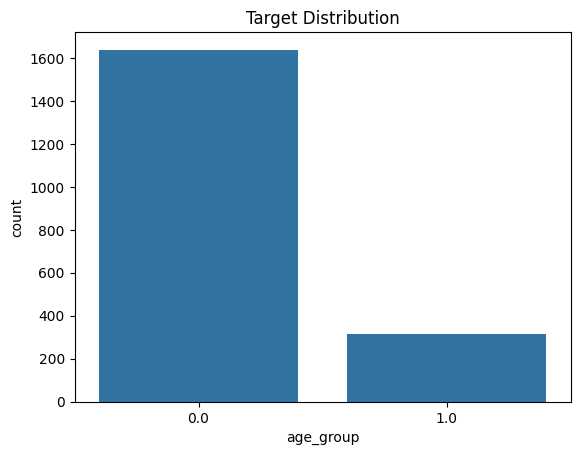

In [86]:
sns.countplot(x='age_group', data=train)
plt.title("Target Distribution")
plt.show()

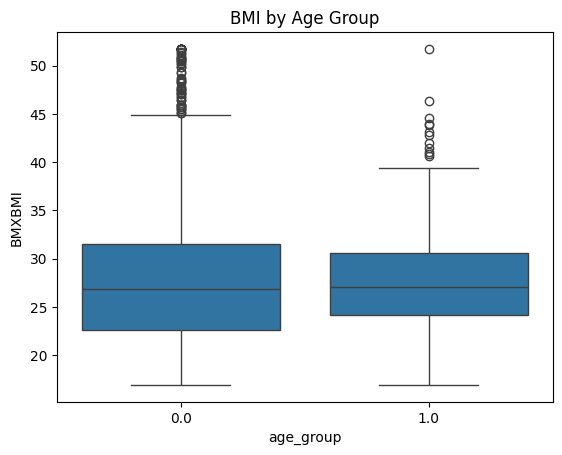

In [87]:
sns.boxplot(x='age_group', y='BMXBMI', data=train)
plt.title("BMI by Age Group")
plt.show()

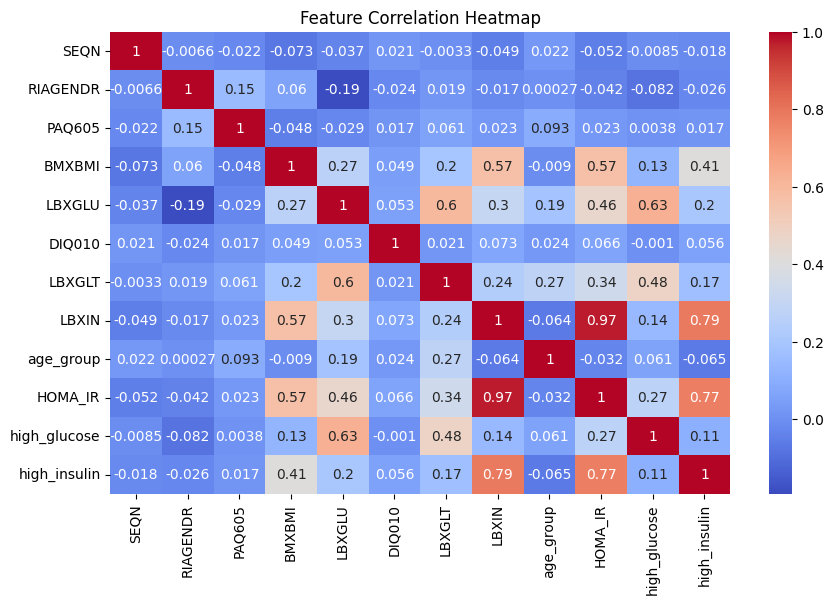

In [88]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [89]:
corr_target = train.corr(numeric_only=True)['age_group'].sort_values(ascending=False)
print(corr_target)

age_group       1.000000
LBXGLT          0.274371
LBXGLU          0.186733
PAQ605          0.092762
high_glucose    0.060683
DIQ010          0.023626
SEQN            0.022023
RIAGENDR        0.000270
BMXBMI         -0.008986
HOMA_IR        -0.032247
LBXIN          -0.064268
high_insulin   -0.064747
Name: age_group, dtype: float64


## Feature Selection

In [90]:
features = ['RIAGENDR', 'PAQ605', 'DIQ010', 'BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN',
            'HOMA_IR', 'high_glucose', 'high_insulin', 'BMI_cat']

In [91]:
X = train[features]
y = train['age_group']

X_test = test[features]

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [96]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

models = {
    "Logistic": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoost": GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    pipe = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)

    score = f1_score(y_val, preds)

    print(f"{name} F1 Score: {score:.4f}")



Logistic F1 Score: 0.1519
RandomForest F1 Score: 0.1667
GradientBoost F1 Score: 0.1667


In [118]:
from sklearn.model_selection import cross_val_score

cv_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

cv_scores = cross_val_score(
    cv_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='f1'
)

print("Cross Validation F1 Mean:", cv_scores.mean())
print("Cross Validation F1 Std:", cv_scores.std())


Cross Validation F1 Mean: 0.4389822357725854
Cross Validation F1 Std: 0.03976416044467228


In [119]:
num_feats = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN', 'HOMA_IR']

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [120]:
cat_feats = ['RIAGENDR', 'PAQ605', 'DIQ010', 'BMI_cat']

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [121]:
bin_feats = ['high_glucose', 'high_insulin']

bin_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

In [122]:
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats),
    ('bin', bin_pipe, bin_feats)
])

In [123]:
# Modeling Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

In [124]:
# Hyperparameter Grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1','l2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [125]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

In [126]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['BMXBMI',
                                                                          'LBXGLU',
                                                                          'LBXGLT',
                                                                          'LBXIN',
                                                                          'HOMA_IR']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy...
                                                                         ['RIAGENDR',
                                                                          'PAQ605',
                                                                          'DIQ010',
                                                                          'BMI_cat']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['high_glucose',
                                                                          'high_insulin'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='f1', verbose=1)

In [127]:
y_val_pred = grid_search.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Validation Accuracy: 71.87%


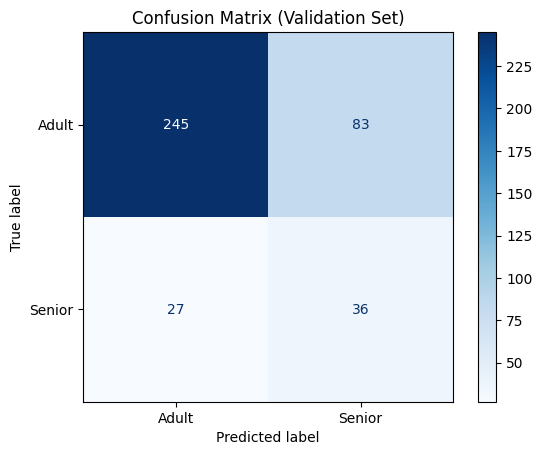

In [128]:
cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm, display_labels=['Adult', 'Senior']).plot(cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.show()

In [129]:
print(classification_report(y_val, y_val_pred, target_names=['Adult', 'Senior']))

              precision    recall  f1-score   support

       Adult       0.90      0.75      0.82       328
      Senior       0.30      0.57      0.40        63

    accuracy                           0.72       391
   macro avg       0.60      0.66      0.61       391
weighted avg       0.80      0.72      0.75       391



In [130]:
y_val_proba = grid_search.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

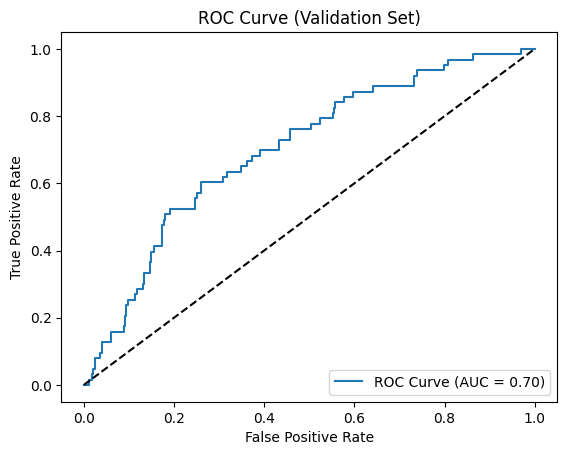

In [131]:
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend(loc="lower right")
plt.show()

In [132]:
train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X, y, cv=cv, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)

In [133]:
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

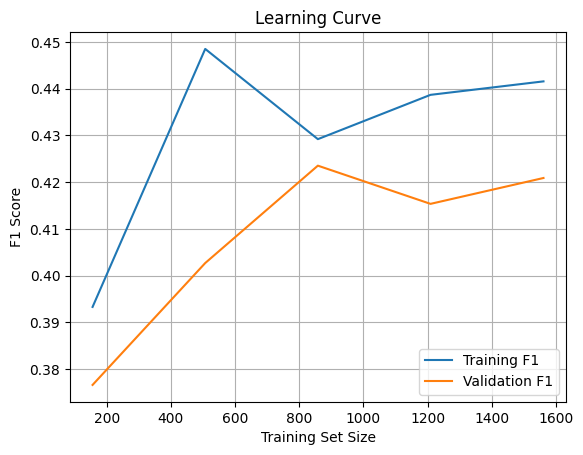

In [134]:
plt.figure()
plt.plot(train_sizes, train_mean, label="Training F1")
plt.plot(train_sizes, val_mean, label="Validation F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [135]:
feature_names = grid_search.best_estimator_.named_steps['preprocessing'].get_feature_names_out()

coeff = grid_search.best_estimator_.named_steps['classifier'].coef_[0]

imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coeff
}).sort_values(by='Importance', ascending=False)

print(imp.head(15))

                     Feature  Importance
2                num__LBXGLT    0.696678
15   cat__BMI_cat_Overweight    0.328279
1                num__LBXGLU    0.284269
0                num__BMXBMI    0.000000
4               num__HOMA_IR    0.000000
6          cat__RIAGENDR_2.0    0.000000
5          cat__RIAGENDR_1.0    0.000000
10           cat__DIQ010_1.0    0.000000
9            cat__PAQ605_7.0    0.000000
12           cat__DIQ010_3.0    0.000000
8            cat__PAQ605_2.0    0.000000
18         bin__high_insulin    0.000000
14        cat__BMI_cat_Obese    0.000000
16  cat__BMI_cat_Underweight    0.000000
17         bin__high_glucose   -0.098728


In [136]:
import joblib

joblib.dump(grid_search.best_estimator_, "nhs_age_model.pkl")
print("Model saved successfully")


Model saved successfully


In [137]:
X_test = X_test.reset_index(drop=True)
test_preds = grid_search.predict(X_test)
submission = pd.DataFrame({'age_group': test_preds.astype(int)})
submission.to_csv('submission.csv', index=False)

In [138]:
print("Submission file created: submission.csv")

Submission file created: submission.csv
